### Eye Pattern Recognition

In [1]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

class EyePatternPredictor:
    def __init__(self):
        # Define patterns with their normal distributions (mean, std)
        self.patterns = {
            'spotted': norm(15, 5),   # Teenagers - scattered, non-linear exploration pattern
            'z_pattern': norm(25, 7),  # Young adults - quick zigzag assessment pattern
            'f_pattern': norm(40, 12), # Middle-aged - horizontal top + vertical left scanning
            'layered': norm(70, 15)    # Elderly - methodical, layer-by-layer reading
        }
        
        self.pattern_names = {
            'spotted': 'Spotted Pattern',
            'z_pattern': 'Z-Pattern',
            'f_pattern': 'F-Pattern',
            'layered': 'Layered Pattern'
        }

    def predict(self, age):
        """Predicts single most likely eye scanning pattern for given age."""
        if age < 0 or age > 120:
            return "Invalid age input"
        
        # small interval (epsilon) around the point
        epsilon = 0.1
        
        probabilities = {
            pattern: dist.cdf(age + epsilon/2) - dist.cdf(age - epsilon/2)
            for pattern, dist in self.patterns.items()
        }
        
        # Normalize probabilities to sum to 1
        total = sum(probabilities.values())
        normalized_probs = {
            k: v/total for k, v in probabilities.items()
        }
        
        # Select pattern with highest probability
        selected_pattern = max(normalized_probs, key=normalized_probs.get)
        return self.pattern_names[selected_pattern]

    def explain_prediction(self, age):
        """Shows detailed probability breakdown for given age."""
        if age < 0 or age > 120:
            return "Invalid age input"
        
        # Get raw probabilities
        raw_probs = {
            pattern: dist.pdf(age) 
            for pattern, dist in self.patterns.items()
        }
        
        # Normalize probabilities
        total = sum(raw_probs.values())
        normalized = {k: v/total for k, v in raw_probs.items()}
        
        print(f"\nProbability breakdown for age {age}:")
        print("\nRaw probabilities (from PDF):")
        for pattern, prob in raw_probs.items():
            print(f"{self.pattern_names[pattern]}: {prob:.4f}")
            
        print("\nNormalized probabilities:")
        for pattern, prob in normalized.items():
            print(f"{self.pattern_names[pattern]}: {prob:.2%}")
            
        winner = max(normalized, key=normalized.get)
        print(f"\nPredicted pattern: {self.pattern_names[winner]}")

    def visualize_distributions(self):
        """Visualizes the probability distributions for all patterns."""
        ages = np.linspace(0, 100, 1000)
        
        plt.figure(figsize=(12, 6))
        
        # Plot each distribution
        for pattern, dist in self.patterns.items():
            probabilities = dist.pdf(ages)
            plt.plot(ages, probabilities, label=self.pattern_names[pattern])
        
        # Plot styling
        plt.title('Eye Scanning Pattern Probabilities by Age')
        plt.xlabel('Age')
        plt.ylabel('Probability Density')
        plt.legend()
        plt.grid(True)
        plt.show()


# Create predictor
predictor = EyePatternPredictor()

# Show distributions
predictor.visualize_distributions()

# Test some predictions
test_ages = [15, 22, 35, 65, 75]
print("\nQuick predictions:")
for age in test_ages:
    pattern = predictor.predict(age)
    print(f"Age {age}: {pattern}")


Quick predictions:
Age 15: Spotted Pattern
Age 22: Z-Pattern
Age 35: F-Pattern
Age 65: Layered Pattern
Age 75: Layered Pattern


In [2]:
# Detailed explanation for one age
predictor.explain_prediction(35)


Probability breakdown for age 35:

Raw probabilities (from PDF):
Spotted Pattern: 0.0000
Z-Pattern: 0.0205
F-Pattern: 0.0305
Layered Pattern: 0.0017

Normalized probabilities:
Spotted Pattern: 0.05%
Z-Pattern: 38.91%
F-Pattern: 57.73%
Layered Pattern: 3.31%

Predicted pattern: F-Pattern


### P(knowledge)

In [3]:
import sys
sys.path.append("omni_parser")

from util.utils import check_ocr_box, get_yolo_model, get_caption_model_processor, get_som_labeled_img
import torch
from PIL import Image
import io
import base64
from typing import Optional

DEVICE = torch.device('cuda')

yolo_model = get_yolo_model(model_path='omni_parser/weights/icon_detect/model.pt')
caption_model_processor = get_caption_model_processor(model_name="florence2", model_name_or_path="omni_parser/weights/icon_caption_florence")

def process(
    image_input,
    box_threshold = 0.05,
    iou_threshold = 0.1,
    use_paddleocr = True,
    imgsz = 640
):

    image_save_path = 'omni_parser/imgs/saved_image_demo.png'
    image_input.save(image_save_path)
    image = Image.open(image_save_path)
    box_overlay_ratio = image.size[0] / 3200
    draw_bbox_config = {
        'text_scale': 0.8 * box_overlay_ratio,
        'text_thickness': max(int(2 * box_overlay_ratio), 1),
        'text_padding': max(int(3 * box_overlay_ratio), 1),
        'thickness': max(int(3 * box_overlay_ratio), 1),
    }

    ocr_bbox_rslt, is_goal_filtered = check_ocr_box(image_save_path, display_img = False, output_bb_format='xyxy', goal_filtering=None, easyocr_args={'paragraph': False, 'text_threshold':0.9}, use_paddleocr=use_paddleocr)
    text, ocr_bbox = ocr_bbox_rslt
    dino_labled_img, label_coordinates, parsed_content_list = get_som_labeled_img(image_save_path, yolo_model, BOX_TRESHOLD = box_threshold, output_coord_in_ratio=True, ocr_bbox=ocr_bbox,draw_bbox_config=draw_bbox_config, caption_model_processor=caption_model_processor, ocr_text=text,iou_threshold=iou_threshold, imgsz=imgsz,)  
    image = Image.open(io.BytesIO(base64.b64decode(dino_labled_img)))
    print('finished processing..')
    # parsed_content_list = '\n'.join([f'icon {i}: ' + str(v) for i,v in enumerate(parsed_content_list)])
    
    return image, parsed_content_list

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-base:
- processing_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-base:
- configuration_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-base-ft:
- configuration_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-base-ft:
- modeling_florence2.py
. Make s

In [4]:
# Display the image using matplotlib
import matplotlib.pyplot as plt

def display_image(image):
    plt.figure(figsize=(12, 8))
    plt.imshow(image)
    plt.axis('off')
    plt.show()


0: 1280x608 16 icons, 61.3ms
Speed: 3.6ms preprocess, 61.3ms inference, 114.9ms postprocess per image at shape (1, 3, 1280, 608)
len(filtered_boxes): 19 7
time to get parsed content: 0.41350793838500977
finished processing..


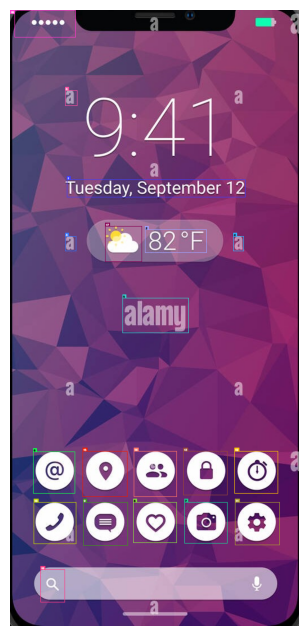

In [5]:
image = Image.open('ui_cropped.jpg')

parsed_image, parsed_content_list = process(image)
display_image(parsed_image)

In [6]:
parsed_content_list[1]

{'type': 'text',
 'bbox': [0.1964980512857437,
  0.2750455439090729,
  0.8132295608520508,
  0.30327868461608887],
 'interactivity': False,
 'content': 'Tuesday,September 12',
 'source': 'box_ocr_content_ocr'}

In [ ]:
from ui_attention_predictor import UIAttentionPredictor, Platform

# Initialize predictor
predictor = UIAttentionPredictor(
    platform=Platform.ANDROID,
    tech_savviness=9
)

elements_data = [
    # {
    #     "type": "button",
    #     "text": "Settings",
    #     "bounds": {
    #         "x1": 0.1,  # These are normalized coordinates (0-1)
    #         "y1": 0.1,
    #         "x2": 0.2,
    #         "y2": 0.2
    #     }
    # },
    # {
    #     "type": "icon",
    #     "text": "menu",
    #     "bounds": {
    #         "x1": 0.8,
    #         "y1": 0.1,
    #         "x2": 0.9,
    #         "y2": 0.2
    #     }
    # }
    {
        "type": item["type"],
        "text": item["content"],
        "bounds": {
            "x1": min(item["bbox"][0], item["bbox"][2]),
            "x2": max(item["bbox"][0], item["bbox"][2]),
            "y1": min(1-item["bbox"][1], 1-item["bbox"][3]),
            "y2": max(1-item["bbox"][1], 1-item["bbox"][3])
        }
    }
    for item in parsed_content_list
]

# Get prediction
result = predictor.predict_attention(
    ui_image=Image.open("ui_cropped.jpg"),
    task="Find the settings menu",
    elements_data=elements_data
)

print(result)